In [4]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm
import sklearn
from sklearn import decomposition
from matplotlib import cm
import torch.nn.functional as F

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

train_ds = torchvision.datasets.FashionMNIST('./', train=True, transform=transform, download=True)
test_ds = torchvision.datasets.FashionMNIST('./', train=False, transform=transform, download=True)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64)

100%|██████████| 26421880/26421880 [00:01<00:00, 17984638.59it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 403423.32it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6333752.37it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14462342.26it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

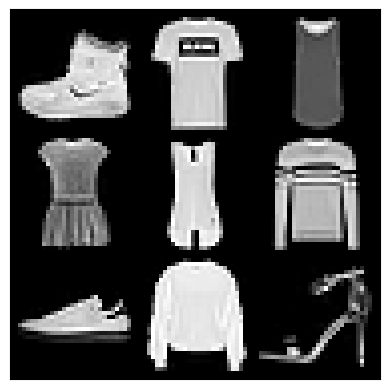

In [ ]:
data, label = next(iter(train_dl))

data = data[:9]
label = label[:9]

grid = torchvision.utils.make_grid(data, 3)

show(grid)

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [ ]:
model = AutoEncoder()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

for epoch in range(10):
    for data, label in tqdm(train_dl):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data)
        loss.backward()
        optimizer.step()

100%|██████████| 938/938 [00:22<00:00, 42.35it/s]


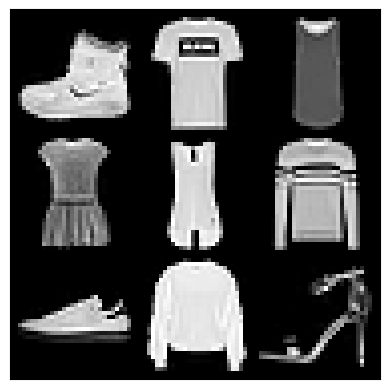

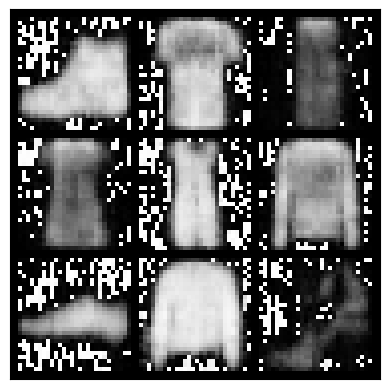

In [ ]:
data, label = next(iter(train_dl))

data = data[:9]
label = label[:9]

out = model(data)

grid_data = torchvision.utils.make_grid(data, 3)
grid_out = torchvision.utils.make_grid(out, 3)

show(grid_data)
plt.show()

show(grid_out)
plt.show()

In [ ]:
encodings = []
labels = []
for i, (data, label) in enumerate(train_dl):
    enc = model.encoder(data)
    enc = enc.view(enc.size(0), -1)
    encodings.append(enc)
    labels.append(label.view(label.size(0), -1))

In [ ]:
encodings = torch.vstack(encodings)
labels = torch.vstack(labels)

encodings.shape, labels.shape

(torch.Size([60000, 32]), torch.Size([60000, 1]))

In [ ]:
pca = decomposition.PCA(2)
encodings_2d = pca.fit_transform(encodings.cpu().detach().numpy())

encodings_2d.shape

(60000, 2)

In [ ]:
labels = labels.cpu().detach().numpy().ravel()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


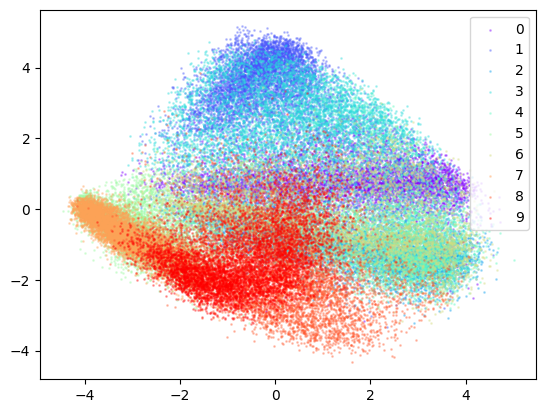

In [ ]:
colors = cm.rainbow(np.linspace(0, 1, 10))

for color, cls in zip(colors, range(10)):
    data = encodings_2d[labels == cls]
    plt.scatter(data[:,0], data[:,1], color=color, alpha=.3, s=1, label=cls)

plt.legend()
plt.show()

In [41]:
class VAE(nn.Module):
    def __init__(self, in_dim, hidden_dim=400, prelatent_dim=200, latent_dim=2):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, prelatent_dim),
            nn.ReLU()
        )
        self.g = nn.Linear(prelatent_dim, latent_dim)
        self.h = nn.Linear(prelatent_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, prelatent_dim),
            nn.ReLU(),
            nn.Linear(prelatent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, in_dim),
            nn.Sigmoid()
        )

    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(mean)
        out = torch.exp(.5 * logvar) * epsilon + mean

        return out

    def encode(self, x):
        out = self.encoder(x)
        mean = self.g(out)
        logvar = self.h(out)
        out = self.reparameterization(mean, logvar)

        return out, mean, logvar

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        encoded, mean, logvar = self.encode(x)
        return self.decode(encoded), mean, logvar

In [48]:
class VAELoss(nn.Module):
    def __init__(self, c):
        super(VAELoss, self).__init__()
        self.C = 1 / (2*c)
        self.bce = nn.BCELoss(reduction='sum')

    def forward(self, input, target, mean, logvar):
        bce = self.bce(input, target)
        kl = - .5 * torch.sum(1 + logvar - mean**2 - torch.exp(logvar), dim=1)
        kl = kl.mean()

        return bce + self.C * kl

In [49]:
mean = torch.tensor([[1], [1], [0]])
var = torch.tensor([[.5], [3], [1]])

kl = - .5 * torch.sum(1 + torch.log(var**2) - mean**2 - var**2, dim=1)

kl

tensor([0.8181, 3.4014, -0.0000])

In [50]:
model = VAE(28*28)
optimizer = torch.optim.Adam(model.parameters())
loss = VAELoss(1)

for epoch in range(1, 16):
    epoch_loss = []

    for data, _ in tqdm(train_dl):
        optimizer.zero_grad()
        data = data.view(data.shape[0], -1)
        out, mean, logvar = model(data)

        l = loss(out, data, mean, logvar)
        epoch_loss.append(l.item())
        l.backward()
        optimizer.step()

    print(f'ended epoch with loss={sum(epoch_loss) / len(epoch_loss)}')

100%|██████████| 938/938 [00:25<00:00, 36.10it/s]


ended epoch with loss=17426.552931145055


100%|██████████| 938/938 [00:31<00:00, 30.14it/s]


ended epoch with loss=16457.470123225947


100%|██████████| 938/938 [00:30<00:00, 30.78it/s]


ended epoch with loss=16274.391343366871


100%|██████████| 938/938 [00:31<00:00, 29.61it/s]


ended epoch with loss=16176.782198452493


100%|██████████| 938/938 [00:30<00:00, 30.51it/s]


ended epoch with loss=16102.870092200827


100%|██████████| 938/938 [00:31<00:00, 29.59it/s]


ended epoch with loss=16049.656633128998


100%|██████████| 938/938 [00:32<00:00, 29.18it/s]


ended epoch with loss=16030.162232226146


100%|██████████| 938/938 [00:31<00:00, 29.40it/s]


ended epoch with loss=15984.87892915445


100%|██████████| 938/938 [00:33<00:00, 27.83it/s]


ended epoch with loss=15939.63057098714


100%|██████████| 938/938 [00:31<00:00, 29.37it/s]


ended epoch with loss=15910.573135994136


100%|██████████| 938/938 [00:33<00:00, 28.17it/s]


ended epoch with loss=15870.048351295976


100%|██████████| 938/938 [00:32<00:00, 29.09it/s]


ended epoch with loss=15852.117769481276


100%|██████████| 938/938 [00:33<00:00, 27.69it/s]


ended epoch with loss=15827.244166652785


100%|██████████| 938/938 [00:33<00:00, 28.37it/s]


ended epoch with loss=15793.167876091085


100%|██████████| 938/938 [00:33<00:00, 27.77it/s]

ended epoch with loss=15793.470432436034


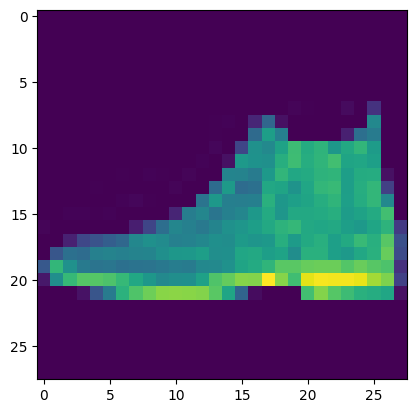

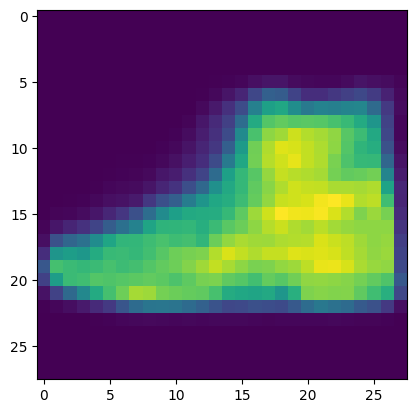

In [55]:
img = next(iter(test_dl))[0][:1]
out, _, _ = model(img.view(1, -1))

plt.imshow(img.view(28, 28))
plt.show()
plt.imshow(out.detach().view(28, 28))
plt.show()